# Bank Churn 분석
- 고객 이탈 예측 모델
- 로지스틱 회귀, KNN, 결정트리, 래덤포레스트, 부스팅 알고리즘 성능 비교


# import

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터

In [32]:
!curl -L https://bit.ly/2MvLrmr -o bank.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   143  100   143    0     0    671      0 --:--:-- --:--:-- --:--:--   674
100    60    0    60    0     0    100      0 --:--:-- --:--:-- --:--:--   344
100   297  100   297    0     0    203      0  0:00:01  0:00:01 --:--:--     0
100  668k  100  668k    0     0   321k      0  0:00:02  0:00:02 --:--:--  321k


In [33]:
data = pd.read_csv('bank.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 특성
- CreditScore : 신용점수
- Tenure : 장기대출
- Balance : 잔고
- NumOfProducts : 은행 계좌 및 제휴 제품 수
- HasCrCard : 은행 신용카드 보유 여부
- IsActiveMember : 활성 고객 여부
- EstimatedSalary : 예상 연봉
- Exited : 이탈 여부

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 탐색적분석

- 이탈했으나, 잔고가 남아있는 고객이 존재한다.
- 활성화 고객(IsActiveMember)이 된다는 것은 무엇을 의미하는가?

### Gender 성별

Male      5457
Female    4543
Name: Gender, dtype: int64


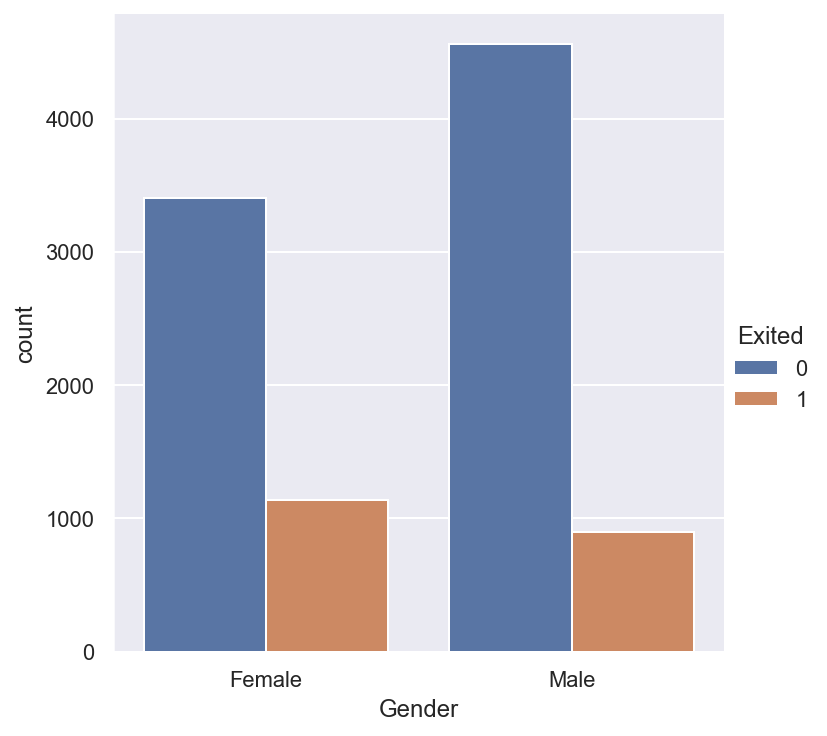

In [35]:
print(data.Gender.value_counts())
sns.catplot(kind='count', data=data, x='Gender', hue="Exited")

- 여성 고객의 이탈 비율이 남성 고객의 이탈 비율보다 크다.

### Age

<AxesSubplot:xlabel='Age', ylabel='count'>

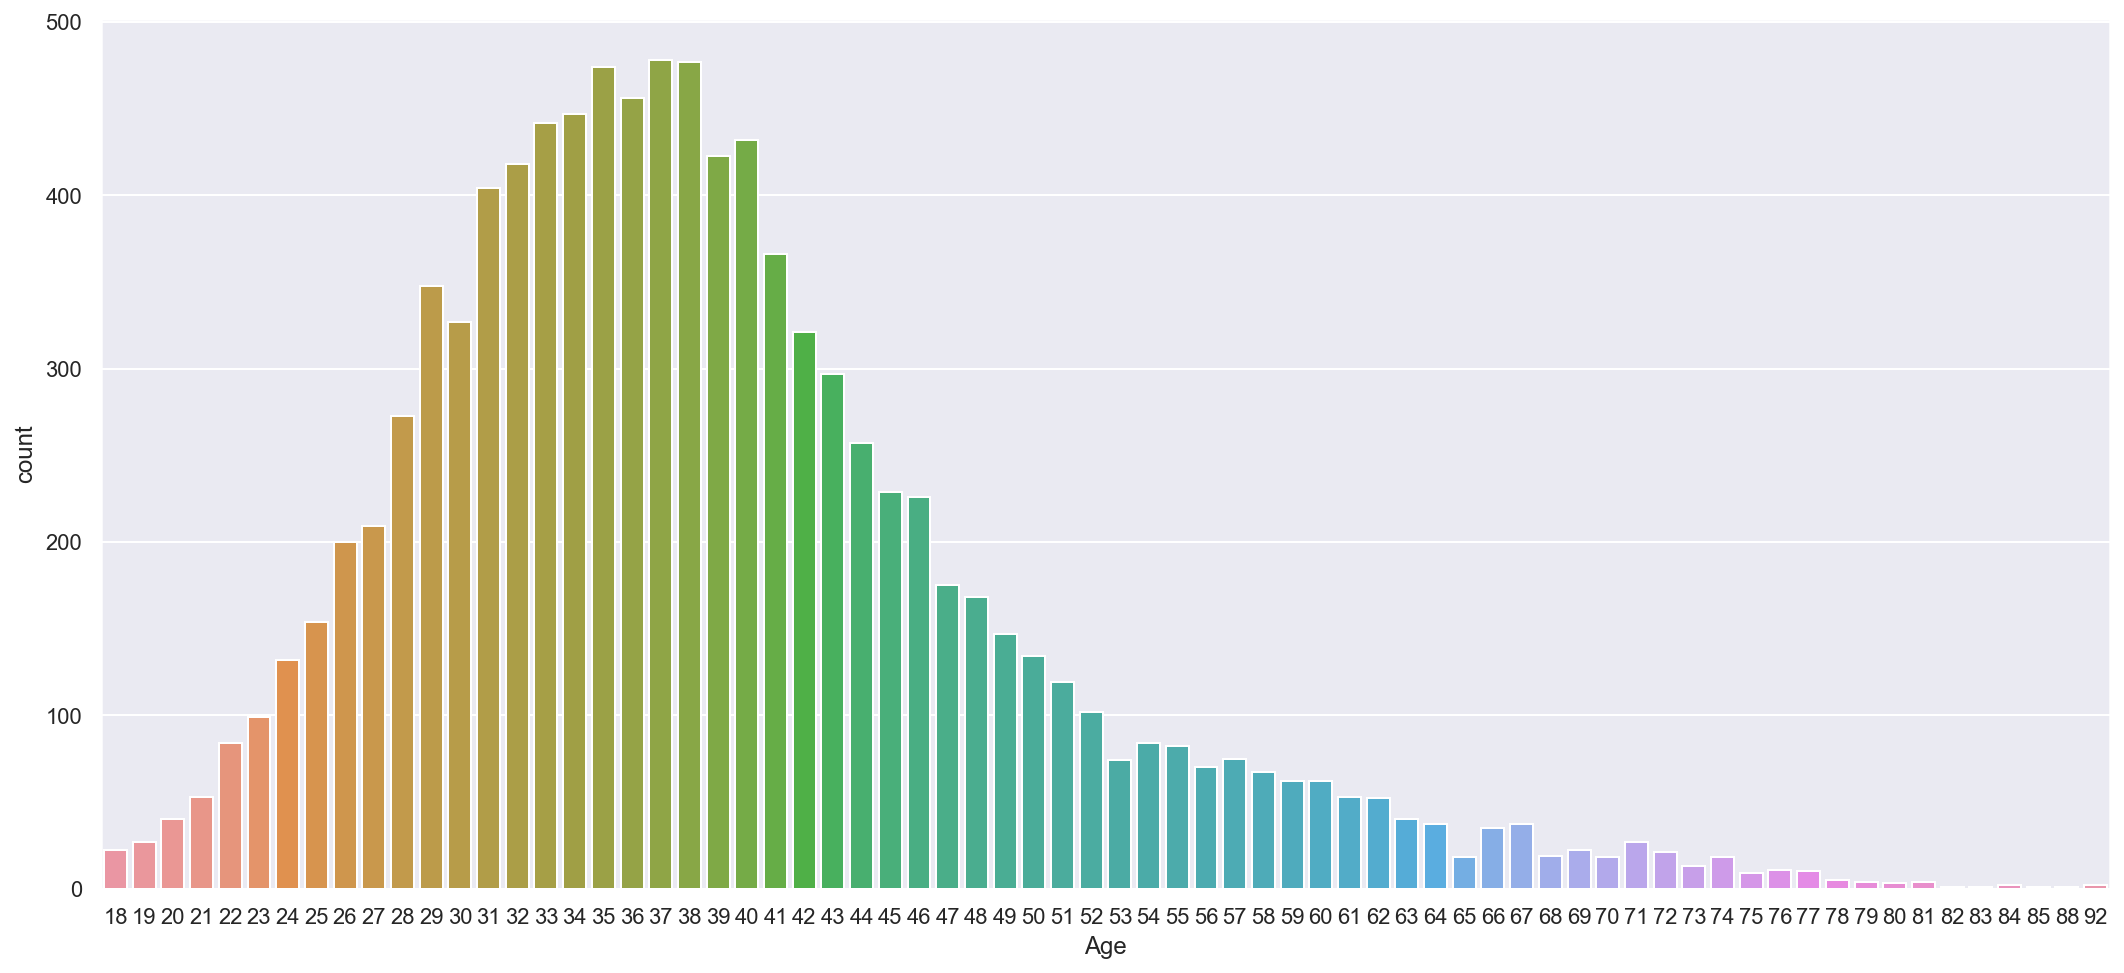

In [36]:
plt.figure(figsize=(18, 8))
sns.countplot(x=data.Age, data=data)

- 데이터에 존재하는 고객의 대부분이 30대이다.

### Geography

<AxesSubplot:xlabel='Geography', ylabel='count'>

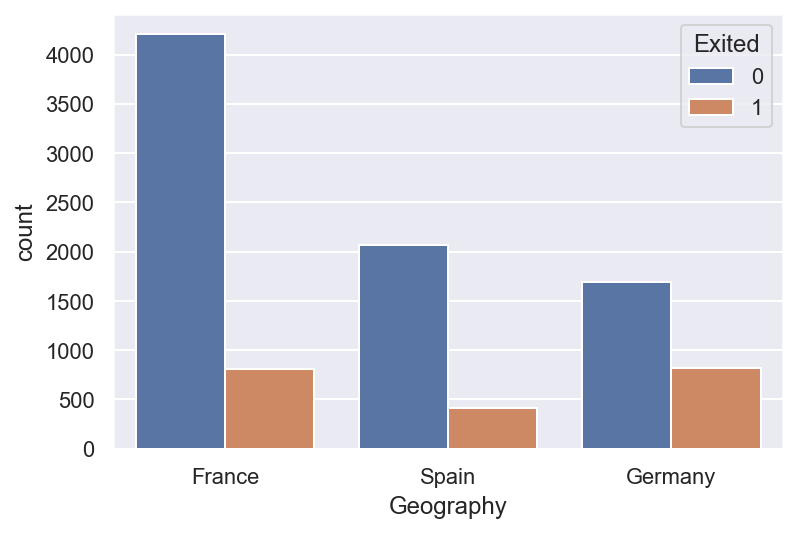

In [37]:
sns.countplot(x='Geography', hue = 'Exited',data = data)

### Tenure

<AxesSubplot:xlabel='Tenure', ylabel='count'>

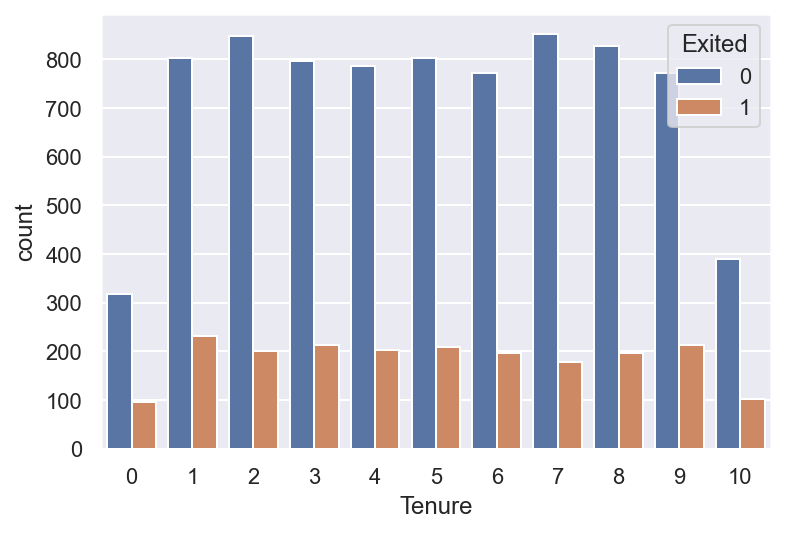

In [38]:
sns.countplot(x='Tenure', data=data, hue="Exited")

### CreditScore

<AxesSubplot:xlabel='Exited', ylabel='CreditScore'>

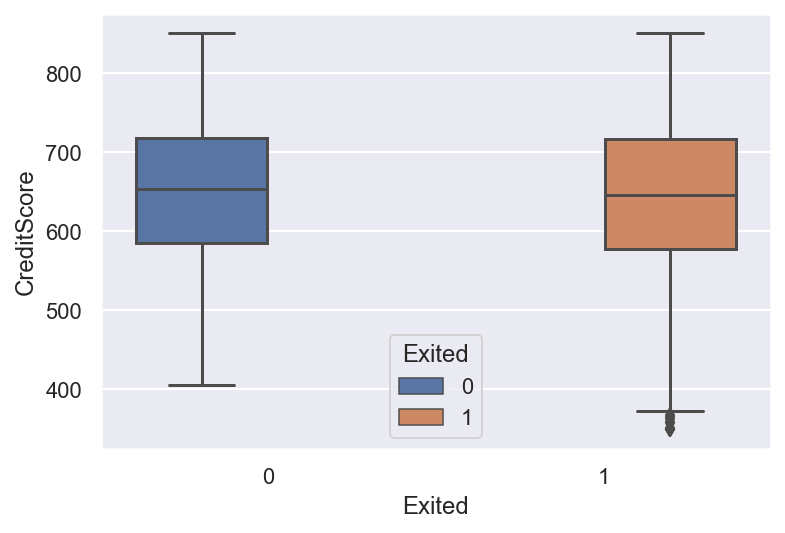

In [39]:
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = data)

- 신용등급의 분포는 이탈 고객과 잔류 고객 간에 유의한 차이가 존재하지 않음.

### Balance

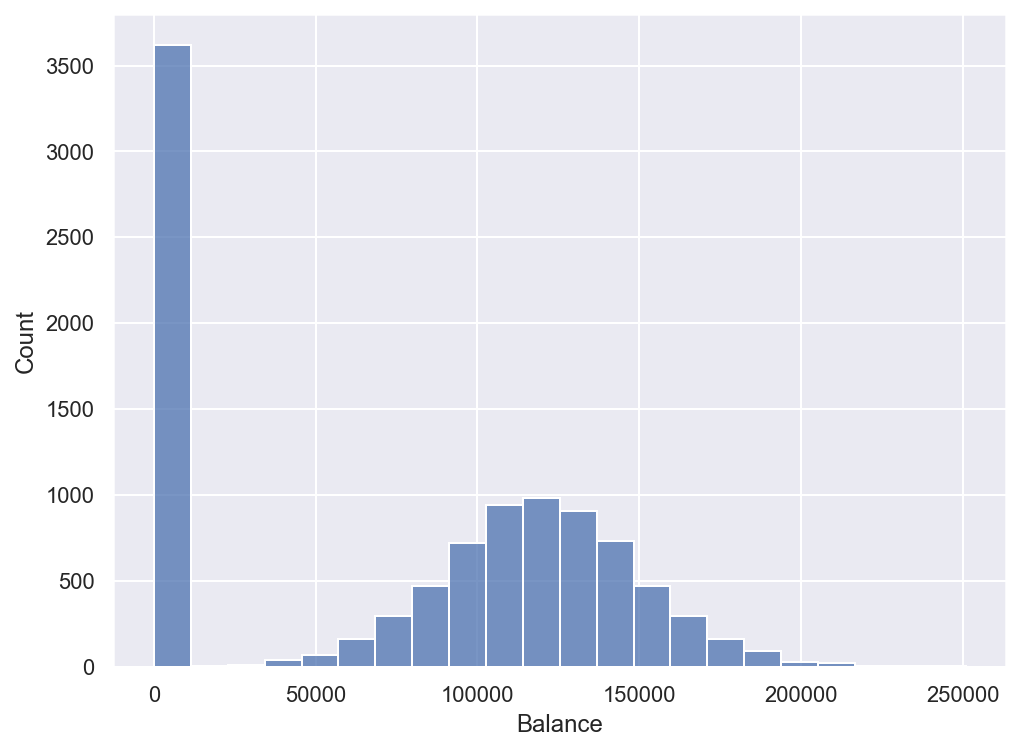

In [40]:
plt.figure(figsize=(8, 6))
sns.histplot(data.Balance);

<AxesSubplot:xlabel='Exited', ylabel='Balance'>

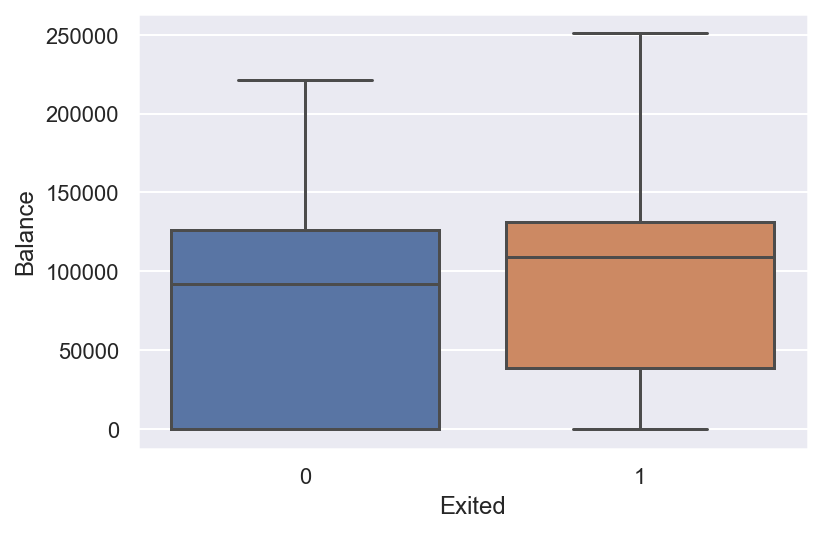

In [41]:
sns.boxplot(x='Exited', y='Balance', data=data)

### NumOfProducts

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64
1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: NumOfProducts, dtype: float64


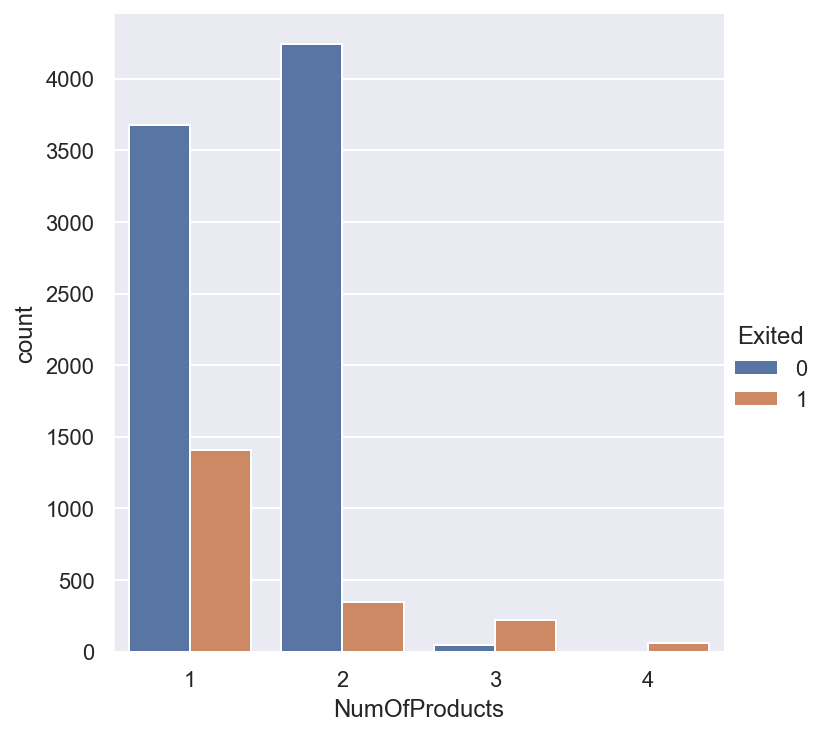

In [42]:
print(data.NumOfProducts.value_counts())
print(data.NumOfProducts.value_counts(normalize=True))
sns.catplot(kind='count', data=data, x='NumOfProducts', hue="Exited")

- 계좌 보유 수에 따른 이탈 : 은행 계좌 및 제휴 제품 수가 3개 이상이면 이탈 고객이 많다

### IsActiveMember

1    5151
0    4849
Name: IsActiveMember, dtype: int64
1    0.5151
0    0.4849
Name: IsActiveMember, dtype: float64


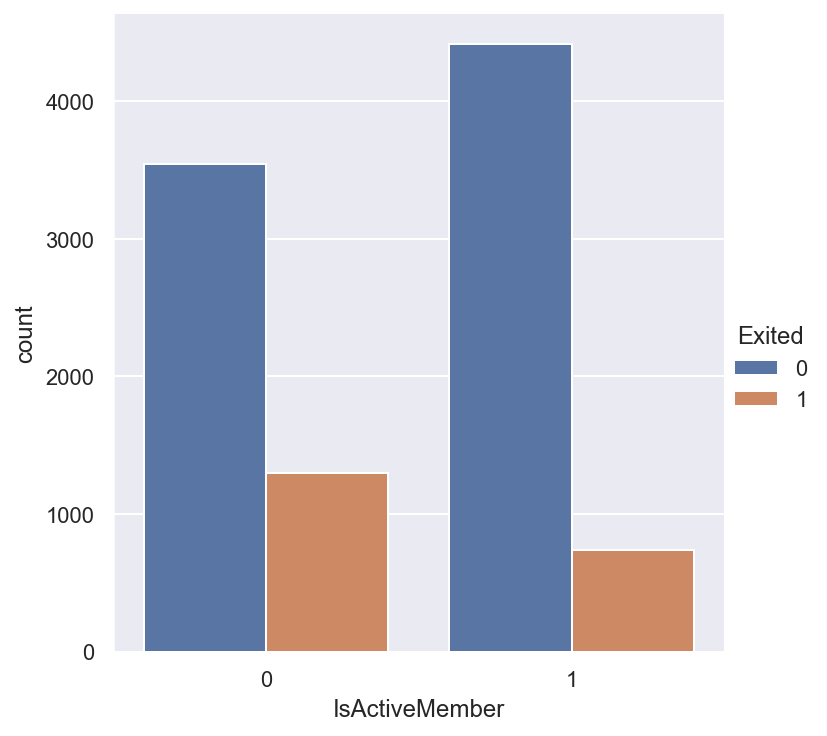

In [43]:
print(data.IsActiveMember.value_counts())
print(data.IsActiveMember.value_counts(normalize=True))
sns.catplot(kind='count', data=data, x='IsActiveMember', hue="Exited")

- 활성화가 되어있지 않은 고객들이 활성화 고객보다 더 높은 비율로 이탈한다.
- 활성화가 되어있지 않은 고객의 비율이 상당히 높다. 이는 고객 이탈에 영향을 미칠 것이기 때문에 은행은 이 그룹을 활성화 고객으로 전환시키기 위해 별도의 프로그램을 시행할 수 있다는 것을 암시한다.

# 전처리

- 고객 이름, 인덱스, ID는 분류에 필요가 없으므로 제거
- 고객 이탈을 분류하는 문제이므로 Exited 특성은 target 변수로 사용

In [45]:
data[:3]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [136]:
y = data['Exited']
X = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)

## 수치로 구성된 특성 추출

In [137]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


In [138]:
X.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [139]:
continuous = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [140]:
X[continuous].head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
0,619,42,2,0.00,101348.88
1,608,41,1,83807.86,112542.58
2,502,42,8,159660.80,113931.57
3,699,39,1,0.00,93826.63
4,850,43,2,125510.82,79084.10


## 범주형 변수 변환(get_dummies)

In [141]:
# 카테고리 변수(object)만 원핫인코딩 한다
pd.get_dummies(X)

# 원핫인코딩시 더미 컬럼수를 하나 줄이는 옵션
# pd.get_dummies(X, drop_first=True)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,0,1,0,0,1


In [142]:
X = pd.get_dummies(X)
X[:3]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0


## 수치형 변수 스케일링

- X 대신 X_sc 정의

In [143]:
scaler = StandardScaler()

# X의 사본을 만든다
X_sc = X.copy()
X_sc[continuous] = scaler.fit_transform(X_sc[continuous])
X_sc[:3]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,1,1,1,0.021886,1,0,0,1,0
1,-0.440036,0.198164,-1.387538,0.117350,1,0,1,0.216534,0,0,1,1,0
2,-1.536794,0.293517,1.032908,1.333053,3,1,0,0.240687,1,0,0,1,0


## 데이터 분할
- 훈련 및 검증 데이터 분할

In [144]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, random_state=9)

In [145]:
X_train.shape, X_test.shape

((7500, 13), (2500, 13))

## 성능 평가 함수

In [146]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [147]:
## 특성 가중치(중요도) 보는 함수 정의

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(5,5))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

# 머신러닝 모델 비교

## 로지스틱 회귀

- X_sc 사용

In [148]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
show_clf_result(y_test, y_pred)

[[1905   80]
 [ 395  120]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1985
           1       0.60      0.23      0.34       515

    accuracy                           0.81      2500
   macro avg       0.71      0.60      0.61      2500
weighted avg       0.78      0.81      0.78      2500



### 가중치 보기

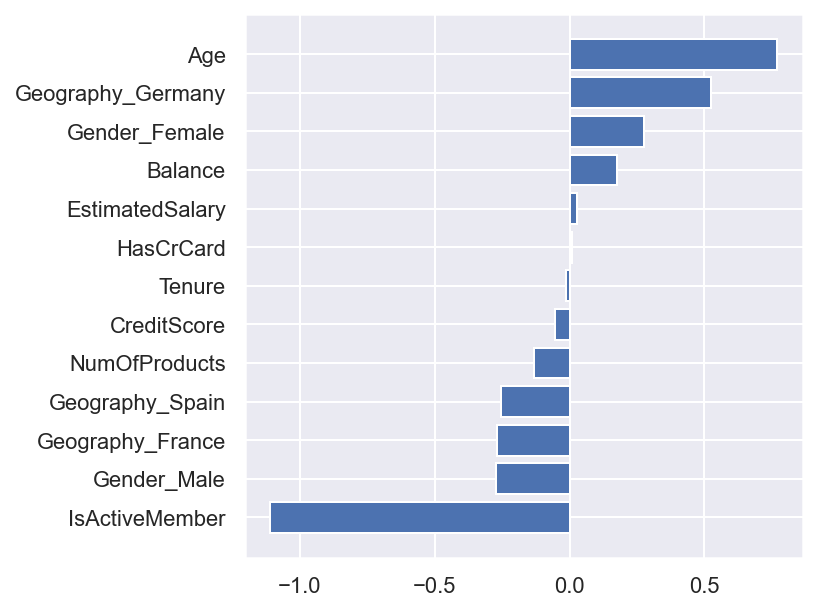

In [149]:
plot_feature_weight(X.columns, model_lr.coef_[0])

### ROC 커브 그리기

In [150]:
def plot_roc(fpr, tpr):

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

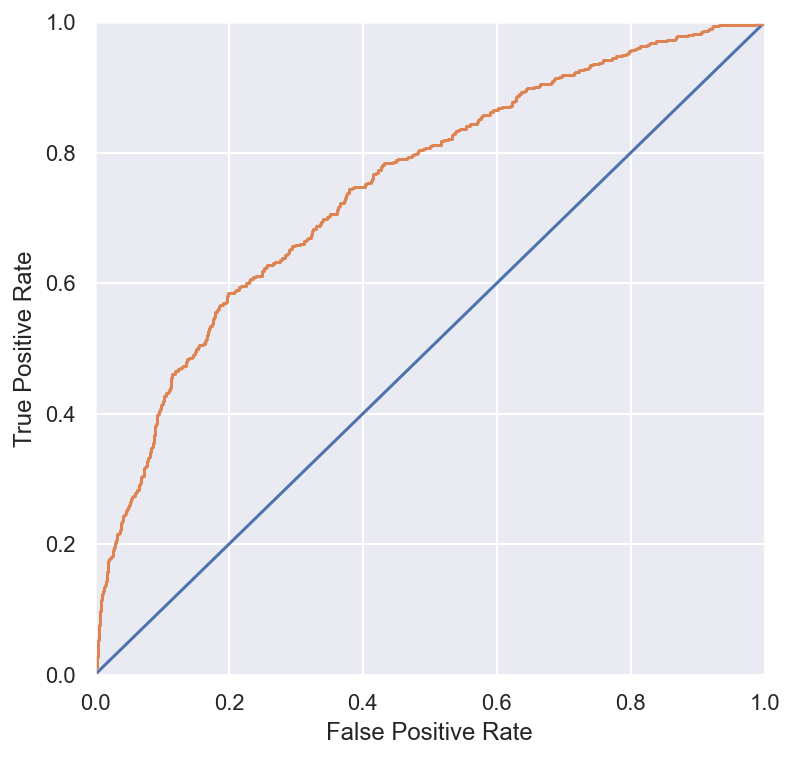

In [151]:
proba = model_lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba)
plot_roc(fpr_lr, tpr_lr)

## KNN

- X_sc 사용

In [152]:
model_knn = KNeighborsClassifier(n_neighbors=7)
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
show_clf_result(y_test, y_pred)

[[1890   95]
 [ 333  182]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1985
           1       0.66      0.35      0.46       515

    accuracy                           0.83      2500
   macro avg       0.75      0.65      0.68      2500
weighted avg       0.81      0.83      0.81      2500



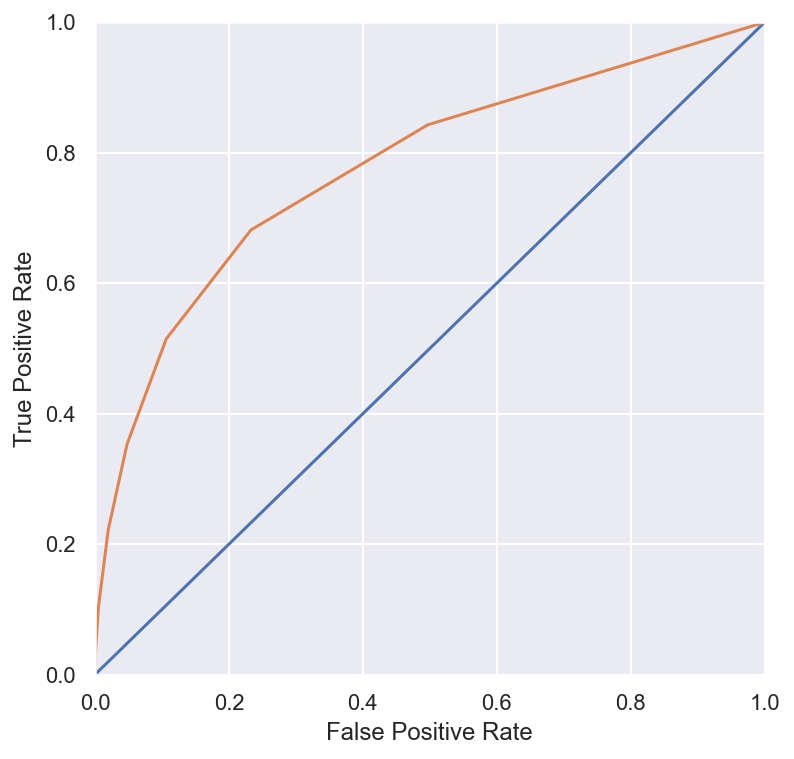

In [153]:
proba = model_knn.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, proba)
plot_roc(fpr_knn, tpr_knn)

## 결정트리
- 스케일링 하지 않은 데이터 X를 사용하면 실제값을 확인하기가 편리하다

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)

In [155]:
## 결정 트리를 이용한 이진 분류
# 트리 모델에서 최적의 depth 구하기

for depth in range(1,20):
    dtc = DecisionTreeClassifier(max_depth=depth) 
    dtc.fit(X_train, y_train) 
    print(depth, dtc.score(X_test, y_test).round(3)) 

1 0.794
2 0.831
3 0.834
4 0.845
5 0.856
6 0.859
7 0.854
8 0.846
9 0.834
10 0.834
11 0.824
12 0.82
13 0.813
14 0.804
15 0.793
16 0.79
17 0.789
18 0.787
19 0.782


In [156]:
dtc = DecisionTreeClassifier(max_depth=6) 
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
show_clf_result(y_test, y_pred)

[[1925   60]
 [ 292  223]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1985
           1       0.79      0.43      0.56       515

    accuracy                           0.86      2500
   macro avg       0.83      0.70      0.74      2500
weighted avg       0.85      0.86      0.84      2500



### 특성 중요도 보기

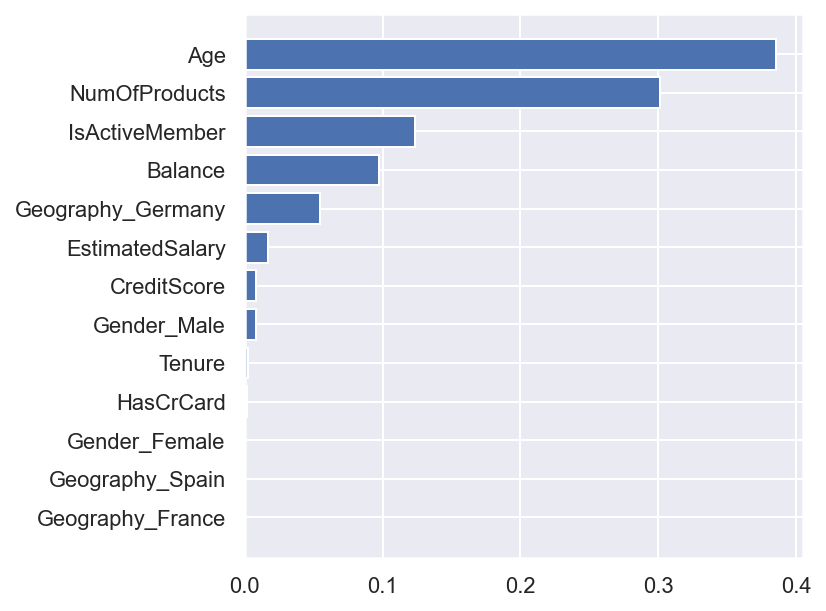

In [157]:
plot_feature_weight(X.columns, dtc.feature_importances_)

### 트리 그리기

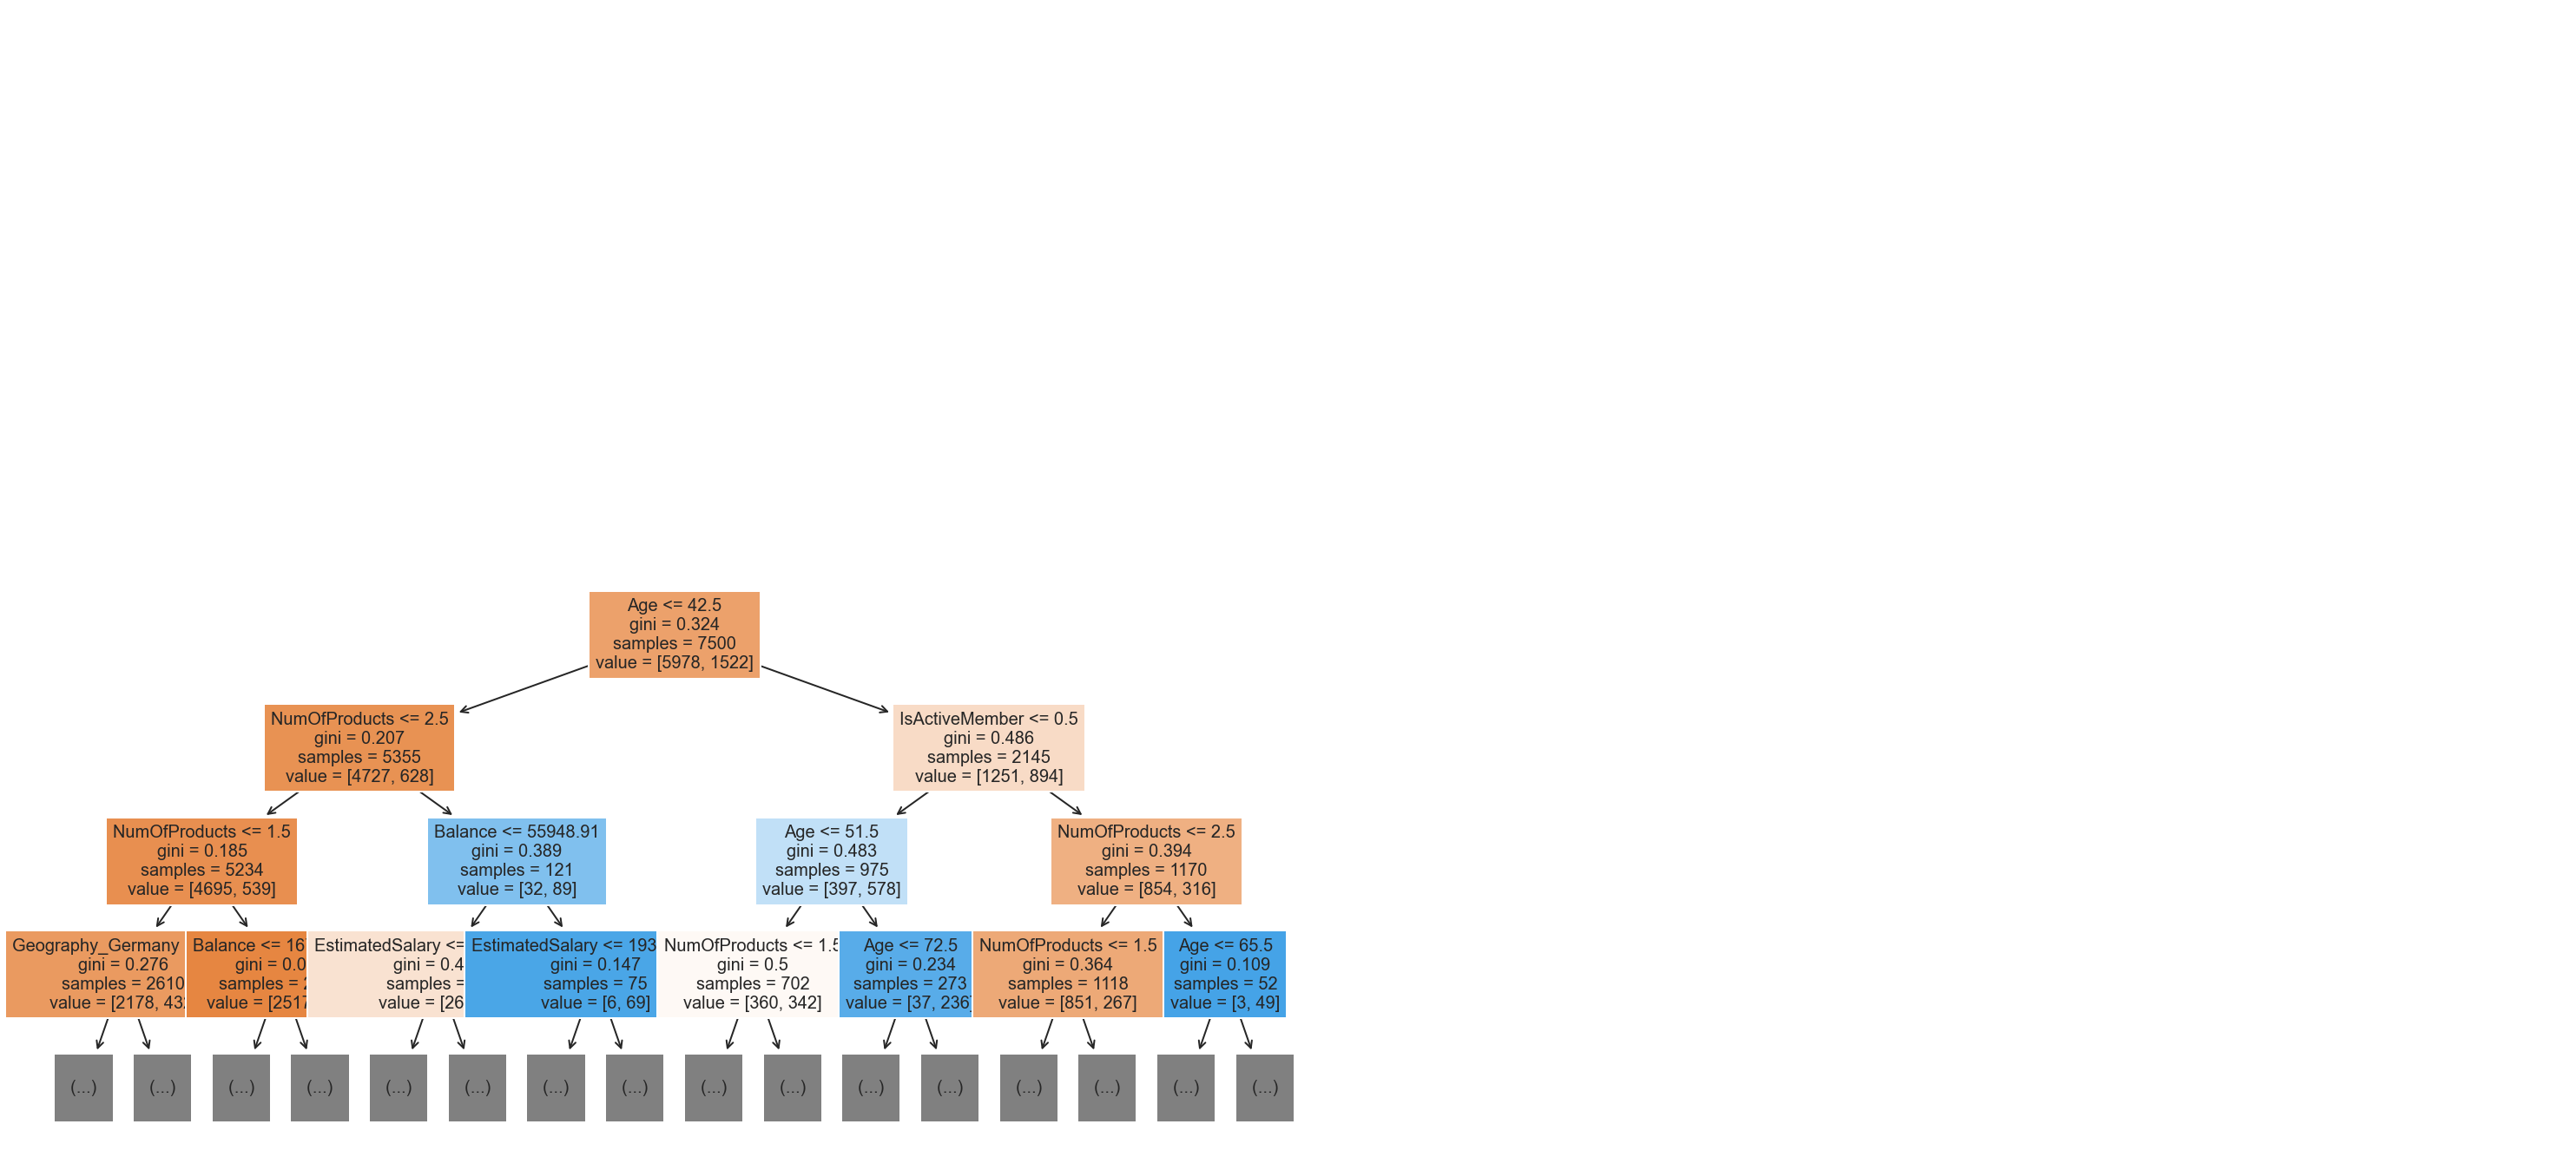

In [158]:
from sklearn import tree
import matplotlib
plt.figure(figsize=(26,12))

tree.plot_tree(dtc, fontsize=10,
              feature_names=list(X.columns),
              filled=True,
              impurity=True,
              max_depth=3)
plt.show()

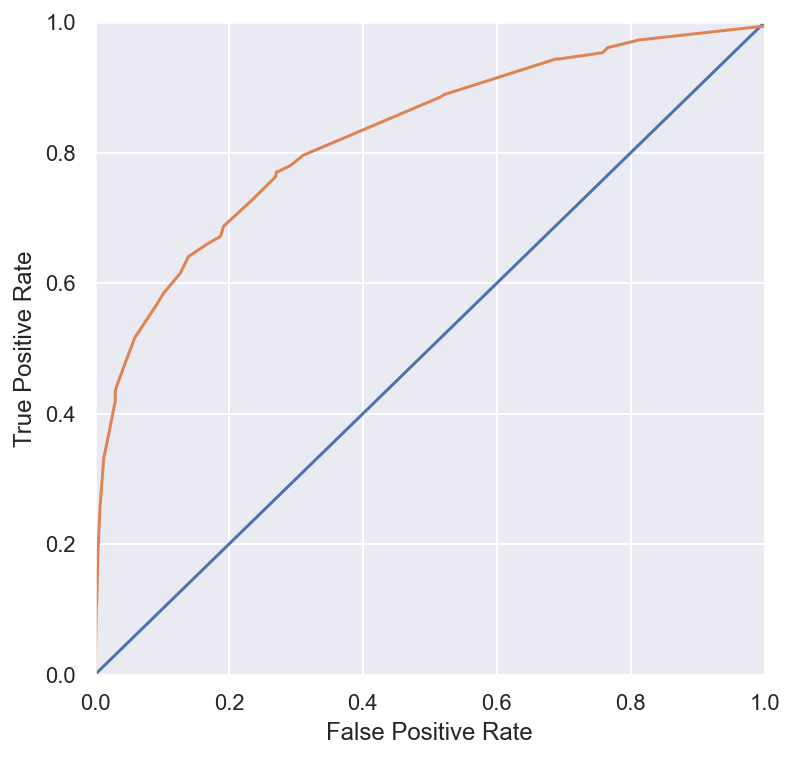

In [159]:
proba = dtc.predict_proba(X_test)[:,1]
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, proba)
plot_roc(fpr_dtc, tpr_dtc)

## 그라디언트 부스팅

In [160]:
lgbm_c = LGBMClassifier()
lgbm_c.fit(X_train, y_train)
y_pred = lgbm_c.predict(X_test)
show_clf_result(y_test, y_pred)

[[1882  103]
 [ 249  266]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1985
           1       0.72      0.52      0.60       515

    accuracy                           0.86      2500
   macro avg       0.80      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500



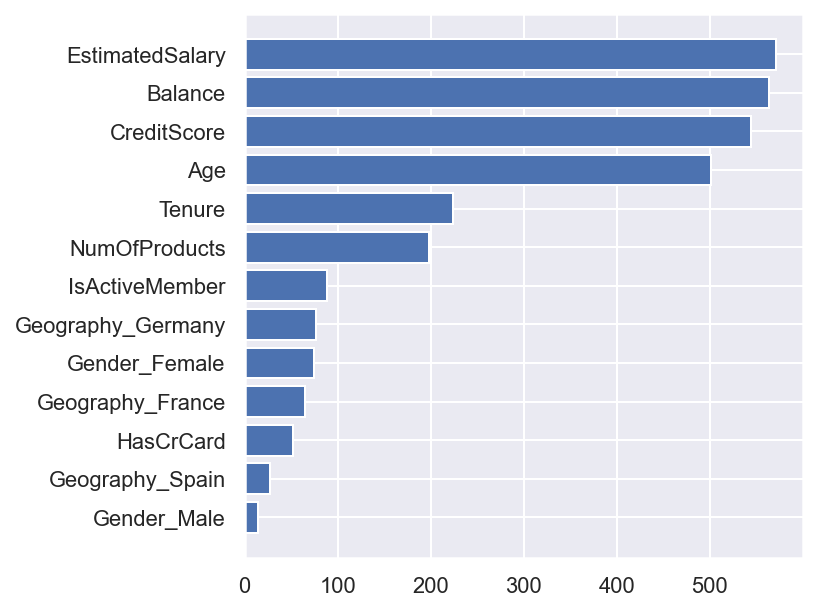

In [161]:
plot_feature_weight(X.columns, lgbm_c.feature_importances_)

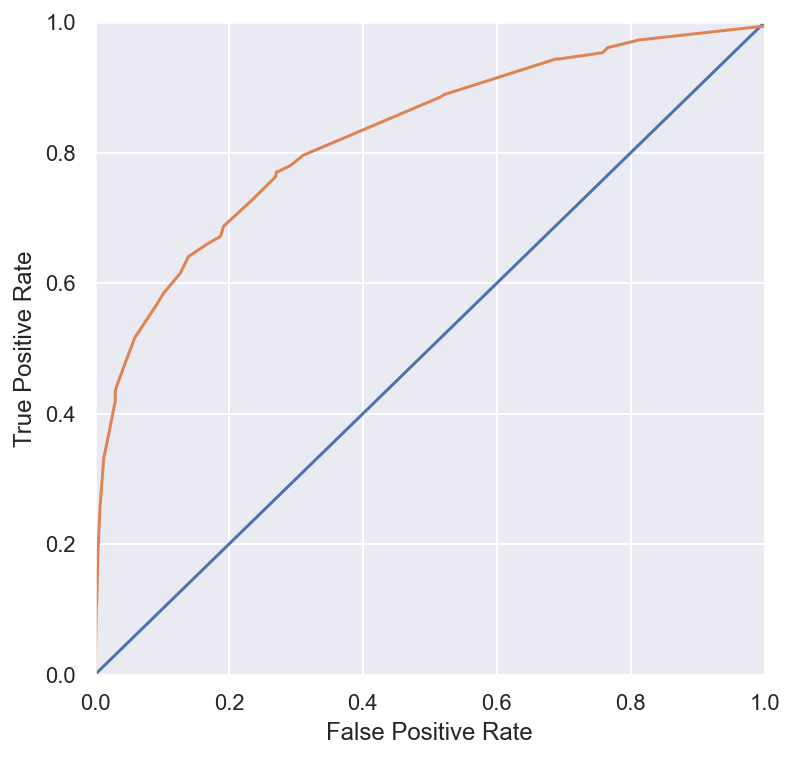

In [162]:
proba = lgbm_c.predict_proba(X_test)[:,1]
fpr_lgbm_c, tpr_lgbm_c, _ = roc_curve(y_test, proba)
plot_roc(fpr_dtc, tpr_dtc)

## 랜덤 포레스트

In [163]:
rfc = RandomForestClassifier(max_depth=6)
rfc.fit(X_train, y_train) 
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

[[1955   30]
 [ 326  189]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1985
           1       0.86      0.37      0.51       515

    accuracy                           0.86      2500
   macro avg       0.86      0.68      0.72      2500
weighted avg       0.86      0.86      0.83      2500



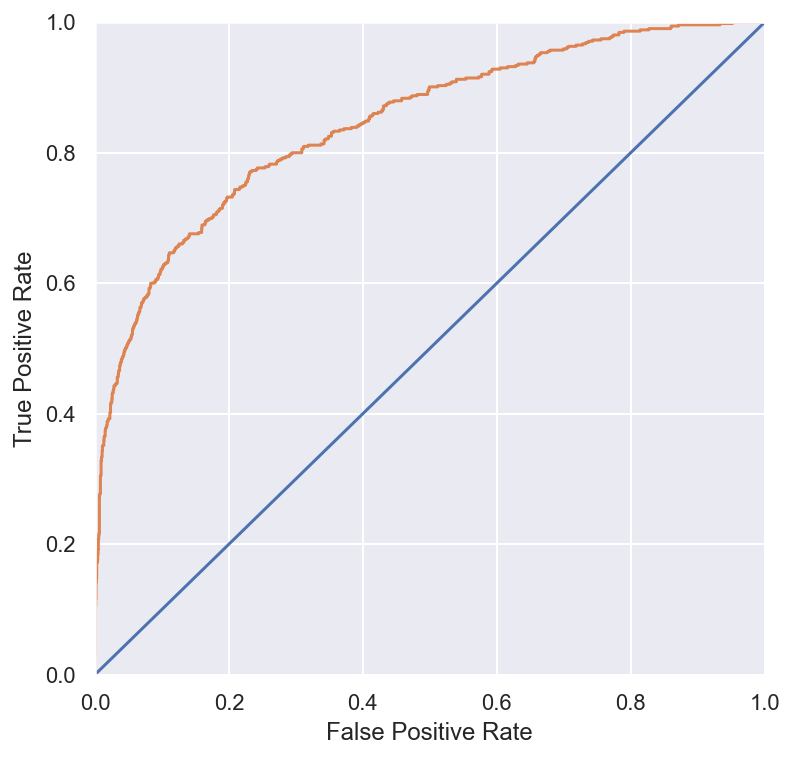

In [164]:
proba = rfc.predict_proba(X_test)[:,1]
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, proba)
plot_roc(fpr_rfc, tpr_rfc)

# 모델 성능 비교

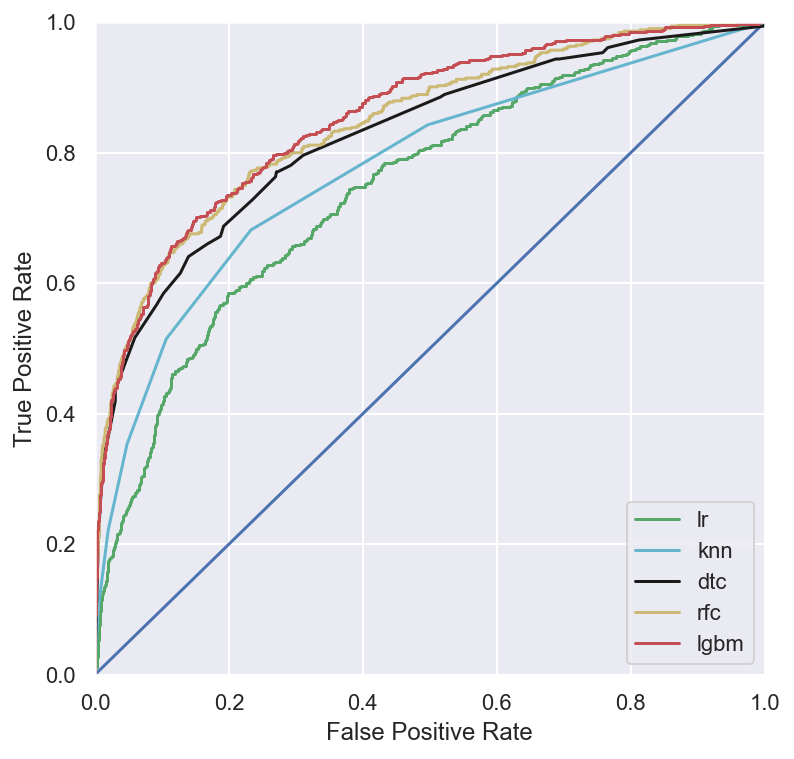

In [165]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1])
plt.plot(fpr_lr, tpr_lr, color='g', label='lr')
plt.plot(fpr_knn, tpr_knn,  color='c', label='knn')
plt.plot(fpr_dtc, tpr_dtc,  color='k', label='dtc')
plt.plot(fpr_rfc, tpr_rfc,  color='y', label='rfc')
plt.plot(fpr_lgbm_c, tpr_lgbm_c, color='r', label='lgbm')
plt.legend()

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()